In [92]:
!pip install -U -q PyDrive 

In [93]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [94]:
import os
import json
import argparse

import numpy as np
from keras.models import Sequential, load_model
from keras.layers import LSTM, Dropout, TimeDistributed, Dense, Activation, Embedding

In [95]:
file1 = open("/content/drive/MyDrive/FYP_Data/input.txt","r")
text=file1.read()

In [96]:
text

'X: 1\nT: The Enchanted Valley\nM: 2/4\nL: 1/16\nB: "O\'Neill\'s 1"\nN: "Very slow" "collected by J. O\'Neill"\nN:\nZ: "Transcribed by Norbert Paap, norbertp@bdu.uva.nl"\nZ:\nK:Gm\nG3-A (Bcd=e) | f4 (g2dB) | ({d}c3-B) G2-E2 | F4 (D2=E^F) |\nG3-A (Bcd=e) | f4 d2-f2 | (g2a2 b2).g2 | {b}(a2g2 f2).d2 |\n(d2{ed}c2) B2B2 | (A2G2 {AG}F2).D2 | (GABc) (d2{ed}c>A) | G2G2 G2z ||\nG | B2c2 (dcAB) | G2G2 G3G | B2d2 (gfdc) | d2g2 (g3ga) |\n(bagf) (gd)d>c | (B2AG) F-D.D2 | (GABc) d2d2 | (bgfd) cA.F2 |\nG2A2 (B2{cB}AG) | A3-G F2-D2 | (GABc) (d2{ed}c>A) | G2G2 G2z2 ||\n\n\nX: 2\nT: Fare You Well\nM: 2/4\nL: 1/16\nB: "O\'Neill\'s 2"\nN: "Slow" "collected by F. O\'Neill"\nZ: "Transcribed by Norbert Paap, norbertp@bdu.uva.nl"\nK:D\nf-g | a3-b g3-a | f4 e3-d | d3-c A3-B | c4 d3-e |\nd3-c (3(A2G2F2) | G4F2-G2 | A-d3 d3-e | d6 ||\nA2 | d3-e f3-g | a4 a3-g | a3-b a3-f | g4 g3-g |\na3-b a3-g | {e}=f4 e3-c | d3-c A3-G | A6 f-g |\na3-b g3-a | f4 e3-d | d3-c A3-B | c4 d3-e |\nd3-c (3(A2G2F2) | G4 F2-G2 | A-d3 d3-

In [97]:
!ls /content/sample_data/model

ls: cannot access '/content/sample_data/model': No such file or directory


In [98]:
MODEL_DIR = '/content/drive/MyDrive/weights'
def save_weights(epoch, model):
    if not os.path.exists(MODEL_DIR):
        os.makedirs(MODEL_DIR)
    model.save_weights(os.path.join(MODEL_DIR, 'weights.{}.h5'.format(epoch)))

In [99]:
#load the weights
def load_weights(epoch, model):
    model.load_weights(os.path.join(MODEL_DIR, 'weights.{}.h5'.format(epoch)))

In [100]:
BATCH_SIZE = 207
SEQ_LENGTH = 64

def read_batches(T, vocab_size):
    length = T.shape[0]; #1,684,914
    batch_chars = int(length / BATCH_SIZE); # 8104

    for start in range(0, batch_chars - SEQ_LENGTH, SEQ_LENGTH): # (0, 8040, 64)
        X = np.zeros((BATCH_SIZE, SEQ_LENGTH)) # 16X64
        Y = np.zeros((BATCH_SIZE, SEQ_LENGTH, vocab_size)) # 16X64X95
        for batch_idx in range(0, BATCH_SIZE): # (0,16)
            for i in range(0, SEQ_LENGTH): #(0,64)
                X[batch_idx, i] = T[batch_chars * batch_idx + start + i] # 
                Y[batch_idx, i, T[batch_chars * batch_idx + start + i + 1]] = 1
        yield X, Y
        

In [101]:
#building the model here with 4 LSTM layers and a Time distributed Layer
#A softmax layer @end to get probablities charater-wise
def build_model(batch_size, seq_len, vocab_size):
    model = Sequential()
    model.add(Embedding(vocab_size, 512, batch_input_shape=(batch_size, seq_len)))
    for i in range(4):
        model.add(LSTM(256, return_sequences=True, stateful=True))
        model.add(Dropout(0.2))

    model.add(TimeDistributed(Dense(vocab_size))) 
    model.add(Activation('softmax'))
    return model

In [102]:
def train(text, epochs, save_freq):

    # character to index and vice-versa mappings
    char_to_idx = { ch: i for (i, ch) in enumerate(sorted(list(set(text)))) }
    print("Number of unique characters: " + str(len(char_to_idx))) #95
    
    with open('/content/drive/MyDrive/char_to_idx.json', 'w') as f:
        json.dump(char_to_idx, f)

    idx_to_char = { i: ch for (ch, i) in char_to_idx.items() }
    vocab_size = len(char_to_idx)

    #model_architecture
    model = build_model(BATCH_SIZE, SEQ_LENGTH, vocab_size)
    model.summary()
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])


    #Train data generation
    T = np.asarray([char_to_idx[c] for c in text], dtype=np.int32) #convert complete text into numerical indices

    print("Length of text:" + str(T.size)) #129,665

    steps_per_epoch = (len(text) / BATCH_SIZE - 1) / SEQ_LENGTH  

    loss_list = []
    accuracy_list = []

    for epoch in range(epochs):
        print('\nEpoch {}/{}'.format(epoch + 1, epochs))
        
        losses, accs = [], []

        for i, (X, Y) in enumerate(read_batches(T, vocab_size)):
            
            #print(X);

            loss, acc = model.train_on_batch(X, Y)
            print('Batch {}: loss = {}, acc = {}'.format(i + 1, loss, acc))
            losses.append(loss)
            accs.append(acc)
        loss_list.append(losses)
        accuracy_list.append(accs)
    # if (epoch + 1) % save_freq == 0:
        save_weights(epoch, model)
        print('Saved checkpoint to', 'weights.{}.h5'.format(epoch))
    return loss_list, accuracy_list


In [142]:
epochs=200
save_freq=2
loss, accuracy = train(text,epochs,save_freq)

Streaming output truncated to the last 5000 lines.
Batch 69: loss = 0.40821418166160583, acc = 0.8637530207633972
Batch 70: loss = 0.401093989610672, acc = 0.87160325050354
Batch 71: loss = 0.38993269205093384, acc = 0.8709239363670349
Batch 72: loss = 0.41422033309936523, acc = 0.8660929799079895
Batch 73: loss = 0.3975159227848053, acc = 0.8713013529777527
Batch 74: loss = 0.38352736830711365, acc = 0.8740187287330627
Batch 75: loss = 0.4069161117076874, acc = 0.8674516677856445
Batch 76: loss = 0.3783174157142639, acc = 0.8760567903518677
Batch 77: loss = 0.36534300446510315, acc = 0.8804348111152649
Batch 78: loss = 0.3786160349845886, acc = 0.8776419162750244
Batch 79: loss = 0.38564395904541016, acc = 0.8730374574661255
Batch 80: loss = 0.38769426941871643, acc = 0.8723580837249756
Batch 81: loss = 0.3828466534614563, acc = 0.8723580837249756
Batch 82: loss = 0.3993455767631531, acc = 0.8676026463508606
Batch 83: loss = 0.38523662090301514, acc = 0.8713013529777527
Batch 84: loss

In [103]:
def build_sample_model(vocab_size):
    model = Sequential()
    model.add(Embedding(vocab_size, 512, batch_input_shape=(1, 1)))
    for i in range(4):
        model.add(LSTM(256, return_sequences=(i != 3), stateful=True))
        model.add(Dropout(0.2))

    model.add(Dense(vocab_size))
    model.add(Activation('softmax'))
    return model

In [104]:
#generating new music by sampling
def sample(epoch, header, num_chars):
    with open('/content/drive/MyDrive/char_to_idx.json') as f:
        char_to_idx = json.load(f)
    idx_to_char = { i: ch for (ch, i) in char_to_idx.items() }
    vocab_size = len(char_to_idx)

    model = build_sample_model(vocab_size)
    load_weights(epoch, model)
    model.save(os.path.join(MODEL_DIR, 'model.{}.h5'.format(epoch)))

    sampled = [char_to_idx[c] for c in header]
    print(sampled)
    

    for i in range(num_chars):
        batch = np.zeros((1, 1))
        if sampled:
            batch[0, 0] = sampled[-1]
        else:
            batch[0, 0] = np.random.randint(vocab_size)
        result = model.predict_on_batch(batch).ravel()
        sample = np.random.choice(range(vocab_size), p=result)
        sampled.append(sample)

    return ''.join(idx_to_char[c] for c in sampled)

In [122]:
epoch=199 #'epoch checkpoint to sample from'
seed='' #'initial character to start for the generated text'
length=1000 #'number of characters to sample'
x = sample(epoch,seed,length)
print(x)

[]
h_**+**	**	>>>}VC D 
 | G3 B  
   GABG  | FAcd   e2  fe  | dcA>B G2 FG | Acde 4    fege   | fdcB  A2 G z |]


X:1454
T:I'm Ecllering Ban
N:"Moderate"
B:O'Neill's 116
Z:Transcribed by henrik.norbeck@mailbox.swipnet.se
M:3/4
L:1/8
K:Dm
d4|d4 (^cd)|(e2 d2) (BG)|A2 A2 (BA)|G3 F G2|
E2 D2 D2|E4 FG|A2 d2 c2|A4 AG|
A2 d2 cA|B2 B2 c2|d3 e {d}c2|A4 gf|
e2 {d}c2 B2|c2 B2 A2|"4"~c2 B2 f2|">"a4 (gf)|
e2 d2 (BA)|G2 F2 ED|E2 E2 (DE)|G2 {AB}A4||


X:163
T:Leat of Jumper
N:"Moderate"
B:O'Neill's 114
Z:Transcribed by henrik.norbeck@mailbox.swipnet.se
M:C
L:1/8
K:A
(e>f)|({e}d>c) ({Bc}A>A) (A>B) {c}(d2 c>A)|({G}(B<d) d>c d2 z g|
(f>e) (a{ag}f) e>(d c/2d/2e/2f/2) ((3gag)|e4 ((3a/g/f/) ((3e/g/a/))|g/e/ ((3fed) =c B z|
((3ABc) (d>e) f>e (d/2c/2d/2c/2)|(A/2G/2) HF-E (F/2G/2) A/2G/2|(FD) D2||


X: 375
T:Wher Is the Lowmer
M:C
L:1/8
B:O'Neill's 534
N:"Moderate" "collected by F. O'Neill"
Z:Transcribed by Dave Wooldridge
K:D
D \
| D2 D E2 F | G2 (F G)d (A/2B/2) | G3 (FG) | (A2 F) (E2 F)|
D G z A (B2 A) | G2 

In [89]:
from music21 import converter

In [108]:
!ls /content/sample_data/song.abc

/content/sample_data/song.abc


ConverterException: ignored

In [60]:
data_directory = '/content/drive/MyDrive/FYP_Data'
charIndex_json = '/content/drive/MyDrive/char_to_idx.json'
model_weights_directory = '/content/drive/MyDrive/weights/'

def generate_sequence(epoch_num, initial_index, seq_length):
    with open(os.path.join(data_directory, charIndex_json)) as f:
        char_to_index = json.load(f)
    index_to_char = {i:ch for ch, i in char_to_index.items()}
    unique_chars = len(index_to_char)
    
    model = build_sample_model(unique_chars)
    model.load_weights(model_weights_directory + "weights.{}.h5".format(epoch_num))
     
    sequence_index = [initial_index]
    
    for _ in range(seq_length):
        batch = np.zeros((1, 1))
        batch[0, 0] = sequence_index[-1]
        
        predicted_probs = model.predict_on_batch(batch).ravel()
        sample = np.random.choice(range(unique_chars), size = 1, p = predicted_probs)
        
        sequence_index.append(sample[0])
    
    seq = ''.join(index_to_char[c] for c in sequence_index)
    
    cnt = 0
    for i in seq:
        cnt += 1
        if i == "\n":
            break
    seq1 = seq[cnt:]
    #above code is for ignoring the starting string of a generated sequence. This is because we are passing any arbitrary 
    #character to the model for generating music. Now, the model start generating sequence from that character itself which we 
    #have passed, so first few characters before "\n" contains meaningless word. Model start generating the music rhythm from
    #next line onwards. The correct sequence it start generating from next line onwards which we are considering.
    
    cnt = 0
    for i in seq1:
        cnt += 1
        if i == "\n" and seq1[cnt] == "\n":
            break
    seq2 = seq1[:cnt]
    #Now our data contains three newline characters after every tune. So, the model has leart that too. So, above code is used for
    #ignoring all the characters that model has generated after three new line characters. So, here we are considering only one
    #tune of music at a time and finally we are returning it..
    
    return [seq, seq1, seq2]

In [61]:

# ep = int(input("1. Which epoch number weight you want to load into the model(10, 20, 30, ..., 90). Small number will generate more errors in music: "))
# ar = int(input("\n2. Enter any number between 0 to 86 which will be given as initial charcter to model for generating sequence: "))
# ln = int(input("\n3. Enter the length of music sequence you want to generate. Typical number is between 300-600. Too small number will generate hardly generate any sequence: "))

# music, music1, music2 = generate_sequence(ep, ar, ln)
music = generate_sequence(199, 86, 500)

print("\nMUSIC SEQUENCE GENERATED: \n")

print(music)


MUSIC SEQUENCE GENERATED: 

['vq+\t\t+++*+\t**+*****xx9C\tWGond"\nB:|D>D .D.G.A.G|F2 G>G A/B/c/A/|(B>A) GF ((3DFG)|\nA2 A>B Ac|A2 (AB/c/) d2|f>e d c/A/|GA|G2||\nd>c|d>c dd/d/|=cB (A/G/)F/A/|(G>A)GF "pp"(AF)|G2 (A>B) (AF)|DE F>G|A2 F>E|\nD2 {A}GF|GF ">"FE ">"F4|">"D4 (F>G)|A4 G>F|\nD2 D2 D2|(DF) (AB) (cd)|e2 f2 (ed)|c4 (Bc)|\nd2 g2 (fe)|d2 {d}c2 (BA)|G2 A2 Bc|(d2 d2 cA)|\nD2 GA {B}A2|G2 G2 {A}GF|G2 {G}F2 D2|D4||\n\n\nX:598\nT:Bealles\'s Man., The\nT:cuasde on .moc air na .maire.\nR:air\nN:"Slow."\nB:O\'Neill\'s 623\nZ:Transcribed by John Walsh (wals', 'B:|D>D .D.G.A.G|F2 G>G A/B/c/A/|(B>A) GF ((3DFG)|\nA2 A>B Ac|A2 (AB/c/) d2|f>e d c/A/|GA|G2||\nd>c|d>c dd/d/|=cB (A/G/)F/A/|(G>A)GF "pp"(AF)|G2 (A>B) (AF)|DE F>G|A2 F>E|\nD2 {A}GF|GF ">"FE ">"F4|">"D4 (F>G)|A4 G>F|\nD2 D2 D2|(DF) (AB) (cd)|e2 f2 (ed)|c4 (Bc)|\nd2 g2 (fe)|d2 {d}c2 (BA)|G2 A2 Bc|(d2 d2 cA)|\nD2 GA {B}A2|G2 G2 {A}GF|G2 {G}F2 D2|D4||\n\n\nX:598\nT:Bealles\'s Man., The\nT:cuasde on .moc air na .maire.\nR:air\nN:"Slow."\nB:O\'

In [64]:
print(music[0])

vq+		+++*+	**+*****xx9C	WGond"
B:|D>D .D.G.A.G|F2 G>G A/B/c/A/|(B>A) GF ((3DFG)|
A2 A>B Ac|A2 (AB/c/) d2|f>e d c/A/|GA|G2||
d>c|d>c dd/d/|=cB (A/G/)F/A/|(G>A)GF "pp"(AF)|G2 (A>B) (AF)|DE F>G|A2 F>E|
D2 {A}GF|GF ">"FE ">"F4|">"D4 (F>G)|A4 G>F|
D2 D2 D2|(DF) (AB) (cd)|e2 f2 (ed)|c4 (Bc)|
d2 g2 (fe)|d2 {d}c2 (BA)|G2 A2 Bc|(d2 d2 cA)|
D2 GA {B}A2|G2 G2 {A}GF|G2 {G}F2 D2|D4||


X:598
T:Bealles's Man., The
T:cuasde on .moc air na .maire.
R:air
N:"Slow."
B:O'Neill's 623
Z:Transcribed by John Walsh (wals


In [65]:
print(music[1])

B:|D>D .D.G.A.G|F2 G>G A/B/c/A/|(B>A) GF ((3DFG)|
A2 A>B Ac|A2 (AB/c/) d2|f>e d c/A/|GA|G2||
d>c|d>c dd/d/|=cB (A/G/)F/A/|(G>A)GF "pp"(AF)|G2 (A>B) (AF)|DE F>G|A2 F>E|
D2 {A}GF|GF ">"FE ">"F4|">"D4 (F>G)|A4 G>F|
D2 D2 D2|(DF) (AB) (cd)|e2 f2 (ed)|c4 (Bc)|
d2 g2 (fe)|d2 {d}c2 (BA)|G2 A2 Bc|(d2 d2 cA)|
D2 GA {B}A2|G2 G2 {A}GF|G2 {G}F2 D2|D4||


X:598
T:Bealles's Man., The
T:cuasde on .moc air na .maire.
R:air
N:"Slow."
B:O'Neill's 623
Z:Transcribed by John Walsh (wals


In [68]:
print(music[2])

B:|D>D .D.G.A.G|F2 G>G A/B/c/A/|(B>A) GF ((3DFG)|
A2 A>B Ac|A2 (AB/c/) d2|f>e d c/A/|GA|G2||
d>c|d>c dd/d/|=cB (A/G/)F/A/|(G>A)GF "pp"(AF)|G2 (A>B) (AF)|DE F>G|A2 F>E|
D2 {A}GF|GF ">"FE ">"F4|">"D4 (F>G)|A4 G>F|
D2 D2 D2|(DF) (AB) (cd)|e2 f2 (ed)|c4 (Bc)|
d2 g2 (fe)|d2 {d}c2 (BA)|G2 A2 Bc|(d2 d2 cA)|
D2 GA {B}A2|G2 G2 {A}GF|G2 {G}F2 D2|D4||



In [45]:
s.converter.subConverters.ConverterMidi()

AttributeError: ignored

In [39]:
abc = converter.subConverters.ConverterABC.parseData(strData=x,  number=None)

TypeError: ignored

In [77]:
# Import Tensorflow 2.0
%tensorflow_version 2.x
import tensorflow as tf 

# Download and import the MIT 6.S191 package
!pip install mitdeeplearning
import mitdeeplearning as mdl

# Import all remaining packages
import numpy as np
import os
import time
import functools
from IPython import display as ipythondisplay
from tqdm import tqdm
# !apt-get install abcmidi timidity > /dev/null 2>&1

# Check that we are using a GPU, if not switch runtimes
#   using Runtime > Change Runtime Type > GPU
# assert len(tf.config.list_physical_devices('GPU')) > 0

In [118]:
music[0]

'vq+\t\t+++*+\t**+*****xx9C\tWGond"\nB:|D>D .D.G.A.G|F2 G>G A/B/c/A/|(B>A) GF ((3DFG)|\nA2 A>B Ac|A2 (AB/c/) d2|f>e d c/A/|GA|G2||\nd>c|d>c dd/d/|=cB (A/G/)F/A/|(G>A)GF "pp"(AF)|G2 (A>B) (AF)|DE F>G|A2 F>E|\nD2 {A}GF|GF ">"FE ">"F4|">"D4 (F>G)|A4 G>F|\nD2 D2 D2|(DF) (AB) (cd)|e2 f2 (ed)|c4 (Bc)|\nd2 g2 (fe)|d2 {d}c2 (BA)|G2 A2 Bc|(d2 d2 cA)|\nD2 GA {B}A2|G2 G2 {A}GF|G2 {G}F2 D2|D4||\n\n\nX:598\nT:Bealles\'s Man., The\nT:cuasde on .moc air na .maire.\nR:air\nN:"Slow."\nB:O\'Neill\'s 623\nZ:Transcribed by John Walsh (wals'

In [83]:
for i, song in enumerate(music[2]): 
  # Synthesize the waveform from a song
  waveform = mdl.lab1.play_song(song)
  

  # If its a valid song (correct syntax), lets play it! 
  if waveform:
    print("Generated song", i)
    ipythondisplay.display(waveform)
    mdl.lab1.play_song(song)


In [149]:
print(len(loss))
print(len(accuracy))

200
200


In [150]:
import statistics
import matplotlib.pyplot as plt

In [151]:
# statistics.mean(loss[0])  
loss_avg = []
loss_median = []
loss_std = []
loss_variance = []
loss_max = []
loss_min = []
for l in loss:
  loss_avg.append(statistics.mean(l))
  loss_median.append(statistics.median(l))
  loss_std.append(statistics.stdev(l))
  loss_variance.append(statistics.variance(l))
  loss_max.append(max(l))
  loss_min.append(min(l))

In [152]:
plt.style.use('seaborn-darkgrid')

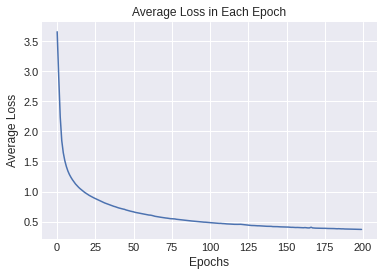

In [153]:
fig = plt.figure()
ax = plt.axes()
ax.plot( [i for i in range(0,200)], loss_avg);
ax.set(xlabel='Epochs', ylabel='Average Loss',title='Average Loss in Each Epoch');

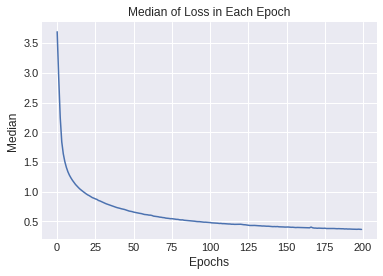

In [154]:
fig = plt.figure()
ax = plt.axes()
ax.plot( [i for i in range(0,200)], loss_median);
ax.set(xlabel='Epochs', ylabel='Median',title='Median of Loss in Each Epoch');

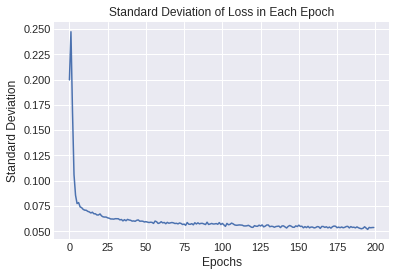

In [155]:
fig = plt.figure()
ax = plt.axes()
ax.plot( [i for i in range(0,200)], loss_std);
ax.set(xlabel='Epochs', ylabel='Standard Deviation',title='Standard Deviation of Loss in Each Epoch');

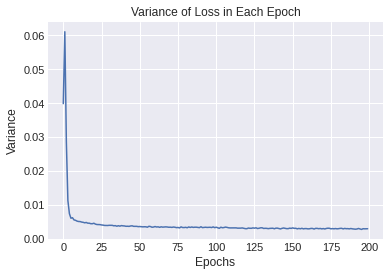

In [156]:
fig = plt.figure()
ax = plt.axes()
ax.plot( [i for i in range(0,200)], loss_variance);
ax.set(xlabel='Epochs', ylabel='Variance',title='Variance of Loss in Each Epoch');

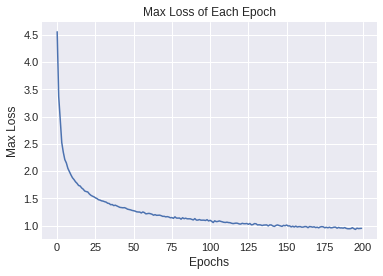

In [157]:
fig = plt.figure()
ax = plt.axes()
ax.plot( [i for i in range(0,200)], loss_max);
ax.set(xlabel='Epochs', ylabel='Max Loss',title='Max Loss of Each Epoch');

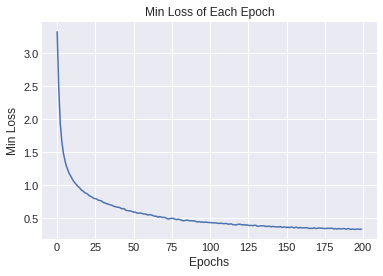

In [158]:
fig = plt.figure()
ax = plt.axes()
ax.plot( [i for i in range(0,200)], loss_min);
ax.set(xlabel='Epochs', ylabel='Min Loss',title='Min Loss of Each Epoch');

In [160]:
acc_avg = []
acc_median = []
acc_std = []
acc_variance = []
acc_max = []
acc_min = []
for a in accuracy:
  acc_avg.append(statistics.mean(a))
  acc_median.append(statistics.median(a))
  acc_std.append(statistics.stdev(a))
  acc_variance.append(statistics.variance(a))
  acc_max.append(max(a))
  acc_min.append(min(a))


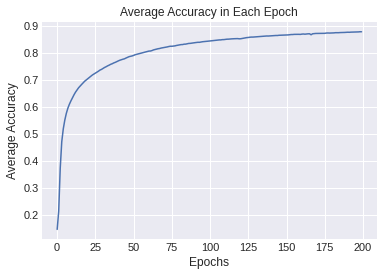

In [161]:
fig = plt.figure()
ax = plt.axes()
ax.plot( [i for i in range(0,200)], acc_avg);
ax.set(xlabel='Epochs', ylabel='Average Accuracy',title='Average Accuracy in Each Epoch');

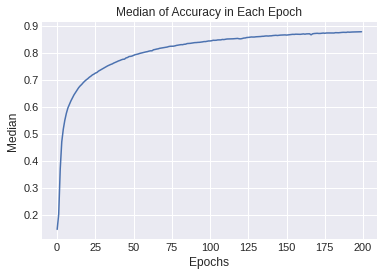

In [162]:
fig = plt.figure()
ax = plt.axes()
ax.plot( [i for i in range(0,200)], acc_median);
ax.set(xlabel='Epochs', ylabel='Median',title='Median of Accuracy in Each Epoch');

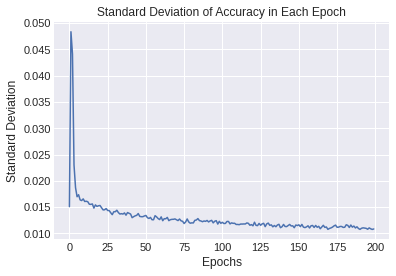

In [163]:
fig = plt.figure()
ax = plt.axes()
ax.plot( [i for i in range(0,200)], acc_std);
ax.set(xlabel='Epochs', ylabel='Standard Deviation',title='Standard Deviation of Accuracy in Each Epoch');

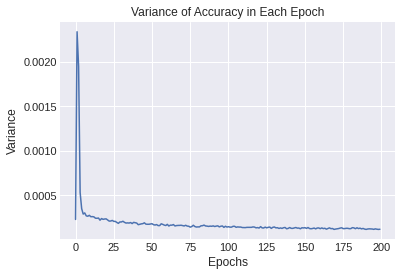

In [164]:
fig = plt.figure()
ax = plt.axes()
ax.plot( [i for i in range(0,200)], acc_variance);
ax.set(xlabel='Epochs', ylabel='Variance',title='Variance of Accuracy in Each Epoch');

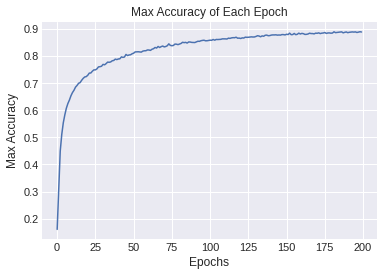

In [165]:
fig = plt.figure()
ax = plt.axes()
ax.plot( [i for i in range(0,200)], acc_max);
ax.set(xlabel='Epochs', ylabel='Max Accuracy',title='Max Accuracy of Each Epoch');

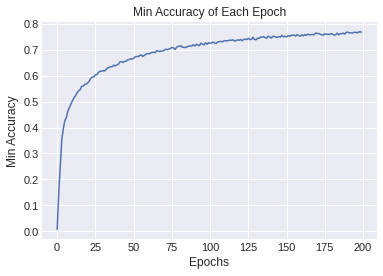

In [166]:
fig = plt.figure()
ax = plt.axes()
ax.plot( [i for i in range(0,200)], acc_min);
ax.set(xlabel='Epochs', ylabel='Min Accuracy',title='Min Accuracy of Each Epoch');